# Project : Telecom Customer Churmprediction
With 21 predictor variables we need to predict whether a particular customer will switch to another telecom provider or not. In telecom terminology, this is referred to as churning and not churning, respectively.

### Importing data

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing all datasets
churn_data = pd.read_csv("churn_data.csv")
customer_data = pd.read_csv("customer_data.csv")
internet_data = pd.read_csv("internet_data.csv")

In [3]:
#Merging on 'customerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')

In [4]:
#Final dataframe with all predictor variables
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')

### Let's understand the structure of our dataframe

In [5]:
# Let's see the head of our master dataset
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [6]:
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [7]:
# Let's see the type of each column
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(1), int64(2), obj

### Data Preparation

In [8]:
# Converting Yes to 1 and No to 0
telecom['PhoneService'] = telecom['PhoneService'].map({'Yes': 1, 'No': 0})
telecom['PaperlessBilling'] = telecom['PaperlessBilling'].map({'Yes': 1, 'No': 0})
telecom['Churn'] = telecom['Churn'].map({'Yes': 1, 'No': 0})
telecom['Partner'] = telecom['Partner'].map({'Yes': 1, 'No': 0})
telecom['Dependents'] = telecom['Dependents'].map({'Yes': 1, 'No': 0})

### Dummy Variable Creation

In [9]:
# Creating a dummy variable for the variable 'Contract' and dropping the first one.
cont = pd.get_dummies(telecom['Contract'],prefix='Contract',drop_first=True)

telecom = pd.concat([telecom,cont],axis=1)

In [10]:
# Creating a dummy variable for the variable 'PaymentMethod' and dropping the first one.
pm = pd.get_dummies(telecom['PaymentMethod'],prefix='PaymentMethod',drop_first=True)

telecom = pd.concat([telecom,pm],axis=1)

In [11]:
# Creating a dummy variable for the variable 'gender' and dropping the first one.
gen = pd.get_dummies(telecom['gender'],prefix='gender',drop_first=True)

telecom = pd.concat([telecom,gen],axis=1)

In [12]:
# Creating a dummy variable for the variable 'MultipleLines' and dropping the first one.
ml = pd.get_dummies(telecom['MultipleLines'],prefix='MultipleLines')

#  dropping MultipleLines_No phone service column
ml1 = ml.drop(['MultipleLines_No phone service'],1)
telecom = pd.concat([telecom,ml1] , axis = 1)

In [13]:
# Creating a dummy variable for the variable 'InternetService' and dropping the first one.
iser = pd.get_dummies(telecom['InternetService'],prefix='InternetService',drop_first=True)

telecom = pd.concat([telecom,iser],axis=1)

In [14]:
# Creating a dummy variable for the variable 'OnlineSecurity'.
os = pd.get_dummies(telecom['OnlineSecurity'] , prefix='OnlineSecurity')

os1= os.drop(['OnlineSecurity_No internet service'],1)
telecom = pd.concat([telecom,os1],axis=1)

In [15]:
# Creating a dummy variable for the variable 'OnlineBackup'.
ob =pd.get_dummies(telecom['OnlineBackup'],prefix='OnlineBackup')

ob1 =ob.drop(['OnlineBackup_No internet service'],1)
telecom = pd.concat([telecom,ob1],axis=1)

In [16]:
# Creating a dummy variable for the variable 'DeviceProtection'. 
dp =pd.get_dummies(telecom['DeviceProtection'],prefix='DeviceProtection')

dp1 = dp.drop(['DeviceProtection_No internet service'],1)
telecom = pd.concat([telecom,dp1],axis=1)

In [17]:
# Creating a dummy variable for the variable 'TechSupport'. 
ts =pd.get_dummies(telecom['TechSupport'],prefix='TechSupport')

ts1 = ts.drop(['TechSupport_No internet service'],1)
telecom = pd.concat([telecom,ts1],axis=1)

In [18]:
# Creating a dummy variable for the variable 'StreamingTV'.
st =pd.get_dummies(telecom['StreamingTV'],prefix='StreamingTV')

st1 = st.drop(['StreamingTV_No internet service'],1)
telecom = pd.concat([telecom,st1],axis=1)

In [19]:
# Creating a dummy variable for the variable 'StreamingMovies'. 
sm =pd.get_dummies(telecom['StreamingMovies'],prefix='StreamingMovies')

sm1 = sm.drop(['StreamingMovies_No internet service'],1)
telecom = pd.concat([telecom,sm1],axis=1)

In [20]:
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,0,1,1,0,1,0,1,0,1,0
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,1,0,0,1,1,0,1,0,1,0
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,1,1,0,1,0,1,0,1,0
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,1,0,0,1,0,1,1,0,1,0
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,1,0,1,0,1,0,1,0,1,0


In [21]:
telecom.shape

(7043, 43)

In [22]:
telecom.isnull().sum()

customerID                               0
tenure                                   0
PhoneService                             0
Contract                                 0
PaperlessBilling                         0
PaymentMethod                            0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
MultipleLines                            0
InternetService                          0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMovies                          0
Contract_One year                        0
Contract_Two year                        0
PaymentMeth

In [23]:
telecom['MultipleLines'].value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

### Dropping the repeated variables

In [24]:
# We have created dummies for the below variables, so we can drop them
telecom = telecom.drop(['Contract','PaymentMethod','gender','MultipleLines','InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'], 1)

In [25]:
#The varaible was imported as a string we need to convert it to float
telecom['TotalCharges'] = telecom['TotalCharges'].convert_objects(convert_numeric=True);
#telecom['tenure'] = telecom['tenure'].astype(int).astype(float)

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [26]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
customerID                               7043 non-null object
tenure                                   7043 non-null int64
PhoneService                             7043 non-null int64
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7032 non-null float64
Churn                                    7043 non-null int64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
Contract_One year                        7043 non-null uint8
Contract_Two year                        7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check        

All the variables are now integer.

### Checking for Outliers

In [27]:
# Checking for outliers in the continuous variables
num_telecom = telecom[['tenure','MonthlyCharges','SeniorCitizen','TotalCharges']]

In [28]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
num_telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,tenure,MonthlyCharges,SeniorCitizen,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,0.162147,2283.300441
std,24.559481,30.090047,0.368612,2266.771362
min,0.000000,18.250000,0.000000,18.800000
25%,9.000000,35.500000,0.000000,401.450000
50%,29.000000,70.350000,0.000000,1397.475000
75%,55.000000,89.850000,0.000000,3794.737500
90%,69.000000,102.600000,1.000000,5976.640000
95%,72.000000,107.400000,1.000000,6923.590000
99%,72.000000,114.729000,1.000000,8039.883000


From the distribution shown above, it can be find out that there no outliner in your data. The numbers are gradually increasing.

### Checking for Missing Values and Inputing Them

In [29]:
# Adding up the missing values (column-wise)
telecom.isnull().sum()

customerID                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
Contract_One year                         0
Contract_Two year                         0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
MultipleLines_No                          0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No                         0
OnlineSecurity_Yes                        0
OnlineBackup_No                 

It means that 11/7043 = 0.001561834 i.e 0.1%, best is to remove these observations from the analysis

In [30]:
# Checking the percentage of missing values
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

customerID                               0.00
tenure                                   0.00
PhoneService                             0.00
PaperlessBilling                         0.00
MonthlyCharges                           0.00
TotalCharges                             0.16
Churn                                    0.00
SeniorCitizen                            0.00
Partner                                  0.00
Dependents                               0.00
Contract_One year                        0.00
Contract_Two year                        0.00
PaymentMethod_Credit card (automatic)    0.00
PaymentMethod_Electronic check           0.00
PaymentMethod_Mailed check               0.00
gender_Male                              0.00
MultipleLines_No                         0.00
MultipleLines_Yes                        0.00
InternetService_Fiber optic              0.00
InternetService_No                       0.00
OnlineSecurity_No                        0.00
OnlineSecurity_Yes                

In [31]:
# Removing NaN TotalCharges rows
telecom = telecom[~np.isnan(telecom['TotalCharges'])]

In [32]:
# Checking percentage of missing values after removing the missing values
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

customerID                               0.0
tenure                                   0.0
PhoneService                             0.0
PaperlessBilling                         0.0
MonthlyCharges                           0.0
TotalCharges                             0.0
Churn                                    0.0
SeniorCitizen                            0.0
Partner                                  0.0
Dependents                               0.0
Contract_One year                        0.0
Contract_Two year                        0.0
PaymentMethod_Credit card (automatic)    0.0
PaymentMethod_Electronic check           0.0
PaymentMethod_Mailed check               0.0
gender_Male                              0.0
MultipleLines_No                         0.0
MultipleLines_Yes                        0.0
InternetService_Fiber optic              0.0
InternetService_No                       0.0
OnlineSecurity_No                        0.0
OnlineSecurity_Yes                       0.0
OnlineBack

Now we don't have any missing values

### Feature Standardisation

In [33]:
# Normalising continuous features
df = telecom[['tenure','MonthlyCharges','TotalCharges']]

In [34]:
normalized_df=(df-df.mean())/df.std()

In [35]:
telecom = telecom.drop(['tenure','MonthlyCharges','TotalCharges'], 1)

In [36]:
telecom = pd.concat([telecom,normalized_df],axis=1)

In [37]:
telecom

,customerID,PhoneService,PaperlessBilling,Churn,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),...,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,1,0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,-1.280157,-1.161611,-0.994123
1,5575-GNVDE,1,0,0,0,0,0,1,0,0,...,1,1,0,1,0,1,0,0.064298,-0.260859,-0.173727
2,3668-QPYBK,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,-1.239416,-0.363897,-0.959581
3,7795-CFOCW,0,0,0,0,0,0,1,0,0,...,1,0,1,1,0,1,0,0.512450,-0.747797,-0.195234
4,9237-HQITU,1,1,1,0,0,0,0,0,0,...,0,1,0,1,0,1,0,-1.239416,0.196164,-0.940391
5,9305-CDSKC,1,1,1,0,0,0,0,0,0,...,1,1,0,0,1,0,1,-0.994970,1.158407,-0.645323
6,1452-KIOVK,1,1,0,0,0,1,0,0,1,...,0,1,0,0,1,1,0,-0.424595,0.807745,-0.147302
7,6713-OKOMC,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,-0.913487,-1.164935,-0.874107
8,7892-POOKP,1,1,1,0,1,0,0,0,0,...,1,0,1,0,1,0,1,-0.180148,1.329583,0.336492
9,6388-TABGU,1,0,0,0,0,1,1,0,0,...,0,1,0,1,0,1,0,1.205048,-0.287450,0.531438


### Checking the Churn Rate

In [38]:
churn = (sum(telecom['Churn'])/len(telecom['Churn'].index))*100

In [39]:
churn

26.578498293515356

We have almost 27% churn rate

## Model Building
Let's start by splitting our data into a training set and a test set.

### Splitting Data into Training and Test Sets

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X = telecom.drop(['Churn','customerID'],axis=1)
y = telecom['Churn']

In [42]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [43]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

### Running Your First Training Model

In [44]:
# Logistic regression model
import statsmodels.api as sm
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())
logm1.fit().summary()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Wed, 05 Feb 2020   Deviance:                       4009.4
Time:                        15:49:59   Pearson chi2:                 6.07e+03
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.2783      1.187     -2.762      0.006      -5.605      -0.952
PhoneService                              0.8213      0.588      1.396      0.163      -0.332       1.974
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
MultipleLines_No                          0.1295      0.205      0.632      0.527      -0.272       0.531
MultipleLines_Yes                         0.6918      0.392      1.763      0.078      -0.077       1.461
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -3.4348      1.324     -2.594      0.009      -6.030      -0.839
OnlineSecurity_No                         0.0905      0.058      1.558      0.119      -0.023       0.204
OnlineSecurity_Yes                        0.0660      0.174      0.380      0.704      -0.275       0.407
OnlineBackup_No                          -0.0088      0.055     -0.161      0.872      -0.116       0.098
OnlineBackup_Yes                          0.1653      0.172      0.960      0.337      -0.172       0.503
DeviceProtection_No                      -0.0832      0.056     -1.487      0.137      -0.193       0.026
DeviceProtection_Yes                      0.2397      0.174      1.379      0.168      -0.101       0.580
TechSupport_No                            0.0935      0.058      1.604      0.109      -0.021       0.208
TechSupport_Yes                           0.0630      0.174      0.362      0.717      -0.278       0.404
StreamingTV_No                           -0.4016      0.133     -3.027      0.002      -0.662      -0.142
StreamingTV_Yes                           0.5581      0.267      2.094      0.036       0.036       1.081
Streaming

### Correlation Matrix

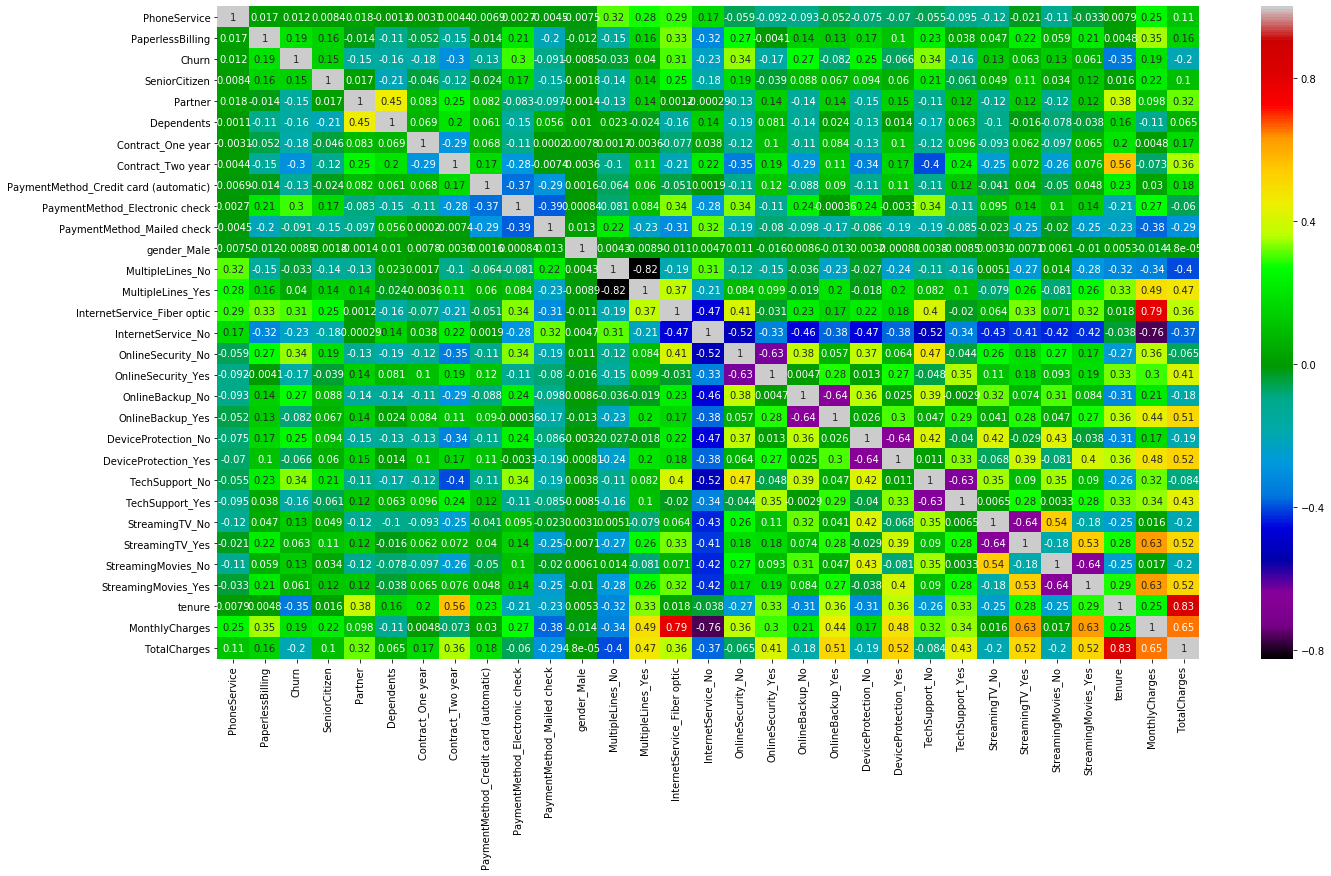

In [45]:
# Let's see the correlation matrix 
plt.figure(figsize = (22,12))        # Size of the figure
sns.heatmap(telecom.corr() , annot = True , cmap = 'nipy_spectral')

### Dropping highly correlated variables.

In [46]:
X_test2 = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No'],1)
X_train2 = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No'],1)

### Checking the Correlation Matrix

After dropping highly correlated variables now let's check the correlation matrix again.

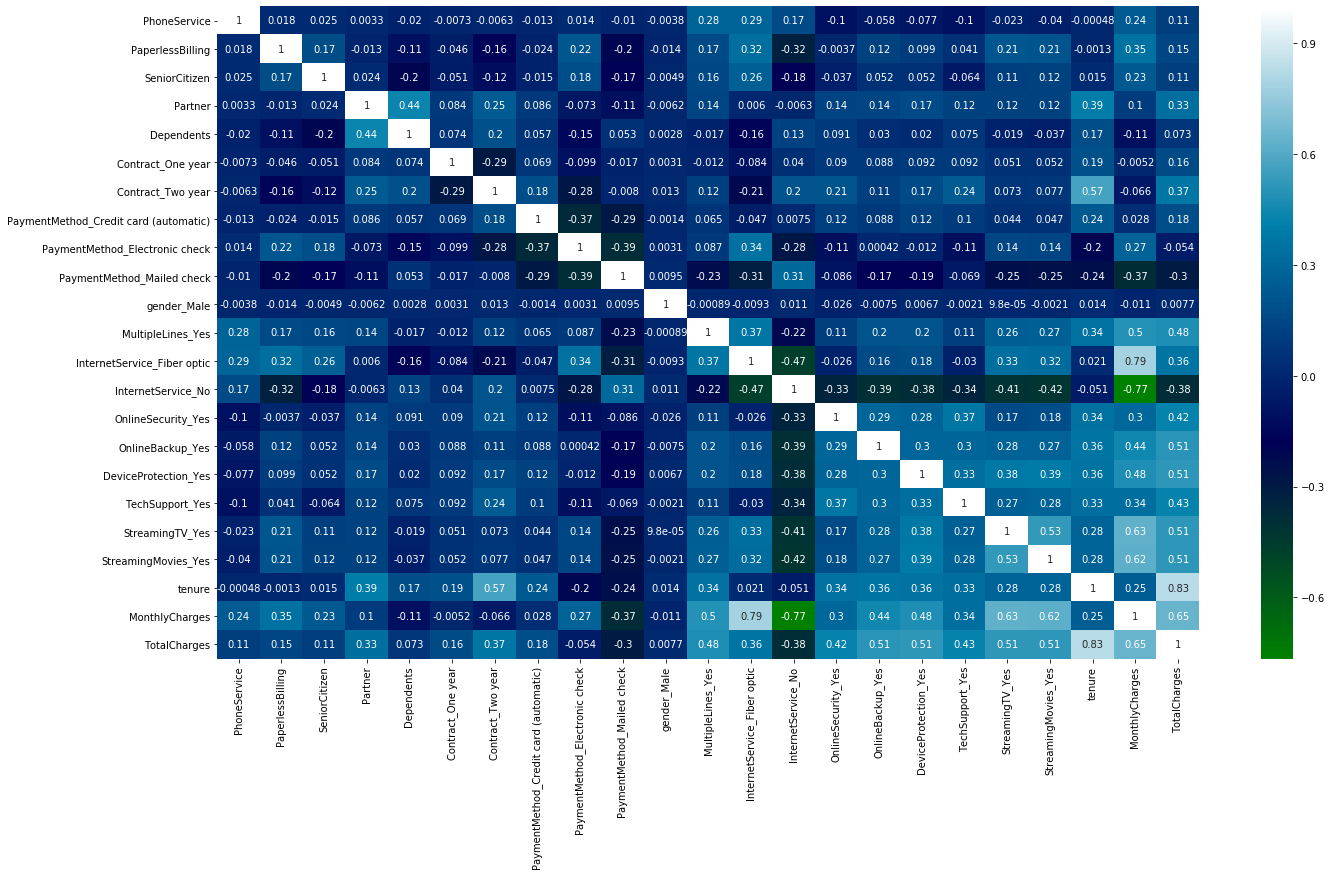

In [47]:
plt.figure(figsize = (22 , 12))
sns.heatmap(X_train2.corr(),annot = True , cmap = 'ocean')

### Re-Running the Model

Now let's run our model again after dropping highly correlated variables

In [48]:
logm2 = sm.GLM(y_train,(sm.add_constant(X_train2)), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Wed, 05 Feb 2020   Deviance:                       4009.4
Time:                        15:50:09   Pearson chi2:                 6.07e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -3.9338      1.545     -2.545      0.011      -6.963      -0.905
PhoneService                              0.9507      0.789      1.205      0.228      -0.595       2.497
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
tenure                                   -1.5198      0.190     -8.015      0.000      -1.891      -1.148
MonthlyCharges                           -2.1817      1.160     -1.880      0.060      -4.456       0.092
TotalCharges                              0.7329      0.198      3.705      0.000       0.345       1.121
=========================================================================================================
"""

### Feature Selection Using RFE

In [49]:
logreg = LogisticRegression()
rfe = RFE(logreg, 13) 
rfe = rfe.fit(X,y)
print(rfe.support_)          
print(rfe.ranking_);          

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[False  True False False False  True  True False  True False False  True
 False  True  True  True False False False False False False False False
  True False  True  True  True  True]
[ 5  1  3 18  4  1  1 11  1 12 17  1 16  1  1  1  7  6 15  9 10  2  8 14
  1 13  1  1  1  1]


In [50]:
# Variables selected by RFE 
col = ['PhoneService', 'PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

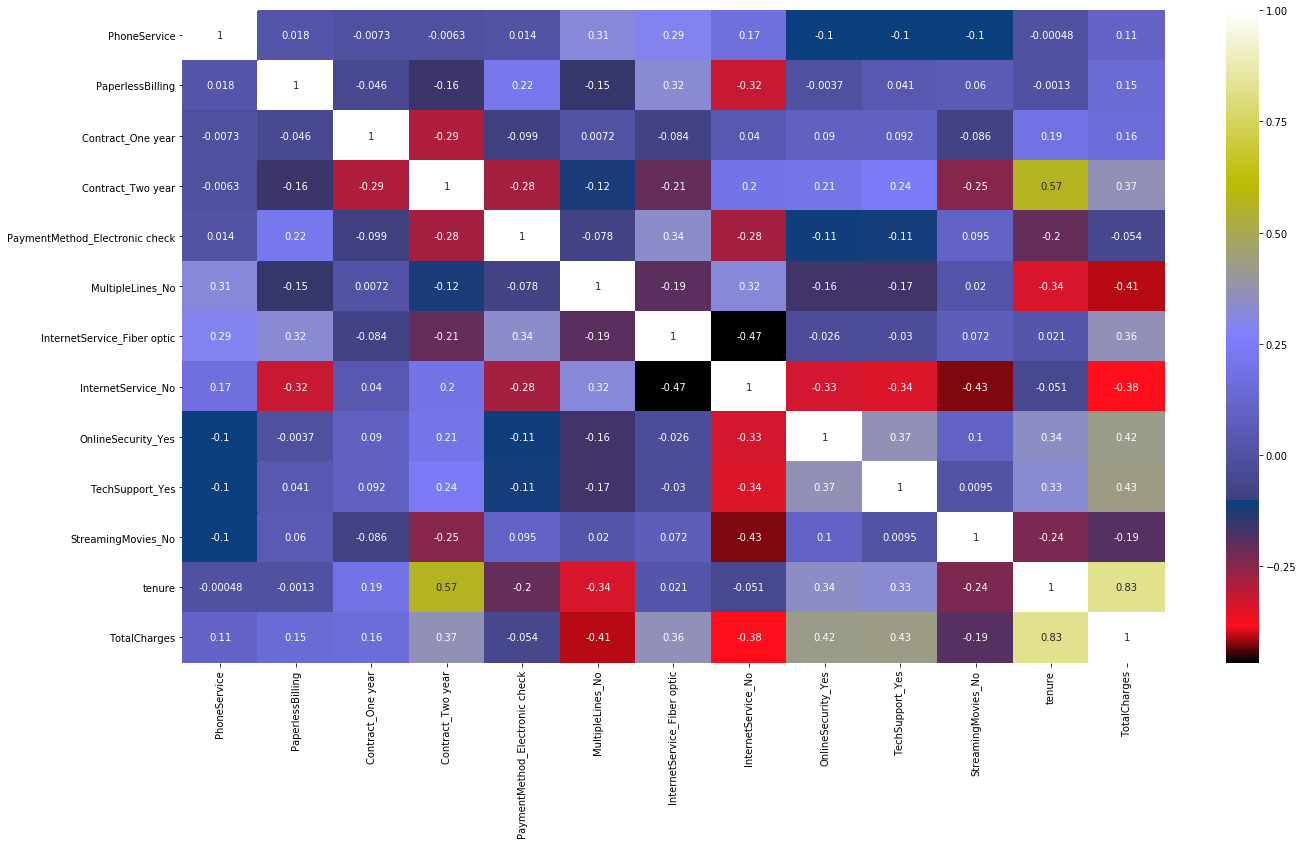

In [51]:
plt.figure(figsize = (22 , 12))
sns.heatmap(X_train[col].corr(),annot = True , cmap = 'gist_stern')

In [52]:
# Let's run the model using the selected variables
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
#Comparing the model with StatsModels
logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm4.fit().summary()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2024.2
Date:                Wed, 05 Feb 2020   Deviance:                       4048.4
Time:                        15:50:12   Pearson chi2:                 6.19e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.0162      0.169     -6.017      0.000      -1.347      -0.685
PhoneService                      -0.3090      0.173     -1.784      0.074      -0.648       0.030
PaperlessBilling                   0.3595      0.089      4.029      0.000       0.185       0.534
Contract_One year                 -0.7012      0.127     -5.516      0.000      -0.950      -0.452
Contract_Two year                 -1.3187      0.210     -6.271      0.000      -1.731      -0.907
PaymentMethod_Electronic check     0.3668      0.083      4.446      0.000       0.205       0.529
MultipleLines_No                  -0.2311      0.095     -2.435      0.015      -0.417      -0.045
InternetService_Fiber optic        0.7937      0.116      6.836      0.000       0.566       1.021
InternetService_No                -1.1832      0.182     -6.484      0.000      -1.541      -0.826
OnlineSecurity_Yes                -0.4107      0.102     -4.031      0.000      -0.610      -0.211
TechSupport_Yes                   -0.4181      0.101     -4.135      0.000      -0.616      -0.220
StreamingMovies_No                -0.2024      0.094     -2.160      0.031      -0.386      -0.019
tenure                            -1.4974      0.181     -8.251      0.000      -1.853      -1.142
TotalCharges                       0.7373      0.186      3.965      0.000       0.373       1.102
==================================================================================================
"""

In [54]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [55]:
telecom.columns
['PhoneService', 'PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

['PhoneService',
 'PaperlessBilling',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'MultipleLines_No',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_Yes',
 'TechSupport_Yes',
 'StreamingMovies_No',
 'tenure',
 'TotalCharges']

In [56]:
# Calculating Vif value
vif_cal(input_data=telecom.drop(['customerID','SeniorCitizen', 'Partner', 'Dependents',
                                 'PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check',
                                 'gender_Male','MultipleLines_Yes','OnlineSecurity_No','OnlineBackup_No',
                                 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
                                 'TechSupport_No','StreamingTV_No','StreamingTV_Yes','StreamingMovies_Yes',
                                 'MonthlyCharges'], axis=1), dependent_col='Churn')

,Var,Vif
0,PhoneService,10.87
12,TotalCharges,8.58
11,tenure,6.80
1,PaperlessBilling,2.61
7,InternetService_No,0.65
3,Contract_Two year,0.28
2,Contract_One year,0.24
9,TechSupport_Yes,0.24
8,OnlineSecurity_Yes,0.21
10,StreamingMovies_No,0.19


### Dropping Variable with high VIF

In [57]:
col = ['PaperlessBilling', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Electronic check','MultipleLines_No','InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes','TechSupport_Yes','StreamingMovies_No','tenure','TotalCharges']

In [58]:
logm5 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm5.fit().summary()

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4909
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.8
Date:                Wed, 05 Feb 2020   Deviance:                       4051.5
Time:                        15:50:12   Pearson chi2:                 6.00e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.1915      0.138     -8.607      0.000      -1.463      -0.920
PaperlessBilling                   0.3563      0.089      3.998      0.000       0.182       0.531
Contract_One year                 -0.6965      0.127     -5.483      0.000      -0.945      -0.448
Contract_Two year                 -1.3078      0.210     -6.230      0.000      -1.719      -0.896
PaymentMethod_Electronic check     0.3700      0.082      4.487      0.000       0.208       0.532
MultipleLines_No                  -0.2990      0.087     -3.442      0.001      -0.469      -0.129
InternetService_Fiber optic        0.7227      0.108      6.666      0.000       0.510       0.935
InternetService_No                -1.2732      0.175     -7.276      0.000      -1.616      -0.930
OnlineSecurity_Yes                -0.4100      0.102     -4.025      0.000      -0.610      -0.210
TechSupport_Yes                   -0.4202      0.101     -4.157      0.000      -0.618      -0.222
StreamingMovies_No                -0.2205      0.093     -2.366      0.018      -0.403      -0.038
tenure                            -1.4276      0.177     -8.066      0.000      -1.774      -1.081
TotalCharges                       0.6495      0.179      3.622      0.000       0.298       1.001
==================================================================================================
"""

In [59]:
# Calculating Vif value
vif_cal(input_data=telecom.drop(['customerID','PhoneService','SeniorCitizen', 'Partner', 'Dependents',
                                 'PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check',
                                 'gender_Male','MultipleLines_Yes','OnlineSecurity_No','OnlineBackup_No',
                                 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
                                 'TechSupport_No','StreamingTV_No','StreamingTV_Yes','StreamingMovies_Yes',
                                 'MonthlyCharges'], axis=1), dependent_col='Churn')

,Var,Vif
11,TotalCharges,8.24
10,tenure,6.56
0,PaperlessBilling,2.44
6,InternetService_No,0.45
2,Contract_Two year,0.26
8,TechSupport_Yes,0.24
1,Contract_One year,0.23
7,OnlineSecurity_Yes,0.21
9,StreamingMovies_No,0.17
3,PaymentMethod_Electronic check,0.05


In [60]:
# Let's run the model using the selected variables
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Making Predictions

In [61]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test[col])

In [62]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [63]:
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

In [64]:
# Let's see the head
y_pred_1.head()

,1
0,0.497860
1,0.370391
2,0.006723
3,0.636464
4,0.007508


In [65]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [66]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [67]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [68]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

In [69]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})

In [70]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['CustID','Churn','Churn_Prob'], axis=1)

C:\Users\Mahmudur Limon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  


In [71]:
# Let's see the head of y_pred_final
y_pred_final.head()

,CustID,Churn,Churn_Prob
0,942,0,0.497860
1,3730,1,0.370391
2,1761,0,0.006723
3,2283,1,0.636464
4,1872,0,0.007508


In [72]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)

In [73]:
# Let's see the head
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted
0,942,0,0.497860,0
1,3730,1,0.370391,0
2,1761,0,0.006723,0
3,2283,1,0.636464,1
4,1872,0,0.007508,0


### Model Evaluation

In [74]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.Churn, y_pred_final.predicted )
confusion

array([[1360,  168],
       [ 249,  333]], dtype=int64)

In [75]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.Churn, y_pred_final.predicted)

0.8023696682464455

In [76]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [77]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.5721649484536082

In [78]:
# Let us calculate specificity
TN / float(TN+FP)

0.8900523560209425

In [79]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.1099476439790576


In [80]:
# positive predictive value 
print (TP / float(TP+FP))

0.6646706586826348


In [81]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8452454940957116


### ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [82]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

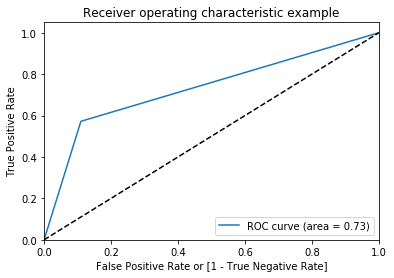

(array([0.        , 0.10994764, 1.        ]),
 array([0.        , 0.57216495, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [83]:
draw_roc(y_pred_final.Churn, y_pred_final.predicted)

### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [84]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,942,0,0.497860,0,1,1,1,1,1,0,0,0,0,0
1,3730,1,0.370391,0,1,1,1,1,0,0,0,0,0,0
2,1761,0,0.006723,0,1,0,0,0,0,0,0,0,0,0
3,2283,1,0.636464,1,1,1,1,1,1,1,1,0,0,0
4,1872,0,0.007508,0,1,0,0,0,0,0,0,0,0,0


In [85]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])


num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.Churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.275829  1.000000  0.000000
0.1   0.1  0.605687  0.943299  0.477094
0.2   0.2  0.695261  0.829897  0.643979
0.3   0.3  0.751659  0.743986  0.754581
0.4   0.4  0.783412  0.666667  0.827880
0.5   0.5  0.802370  0.572165  0.890052
0.6   0.6  0.794787  0.408935  0.941754
0.7   0.7  0.757820  0.176976  0.979058
0.8   0.8  0.727962  0.013746  1.000000
0.9   0.9  0.724171  0.000000  1.000000


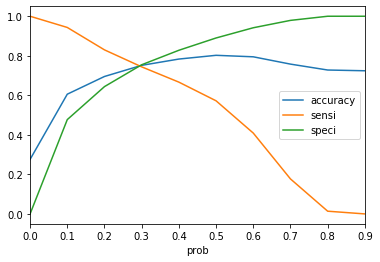

In [86]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci']);

### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [87]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

In [88]:
y_pred_final.head()

,CustID,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,942,0,0.497860,0,1,1,1,1,1,0,0,0,0,0,1
1,3730,1,0.370391,0,1,1,1,1,0,0,0,0,0,0,1
2,1761,0,0.006723,0,1,0,0,0,0,0,0,0,0,0,0
3,2283,1,0.636464,1,1,1,1,1,1,1,1,0,0,0,1
4,1872,0,0.007508,0,1,0,0,0,0,0,0,0,0,0,0


In [89]:
#Let's check the overall accuracy.
metrics.accuracy_score( y_pred_final.Churn, y_pred_final.final_predicted)

0.7516587677725118

In [90]:
metrics.confusion_matrix( y_pred_final.Churn, y_pred_final.final_predicted )

array([[1153,  375],
       [ 149,  433]], dtype=int64)